## Introduction and Data Loading

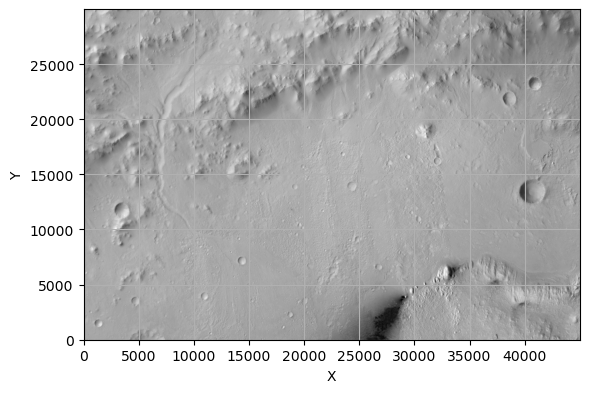

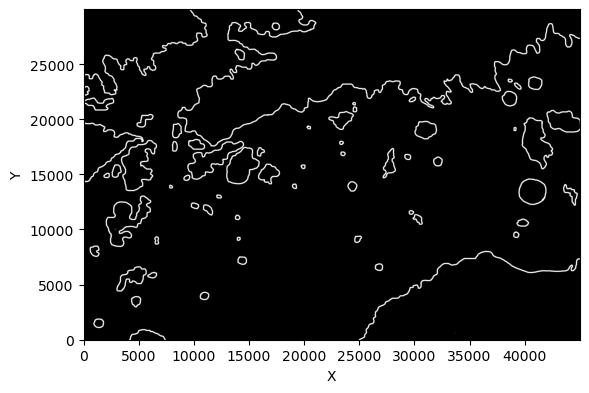

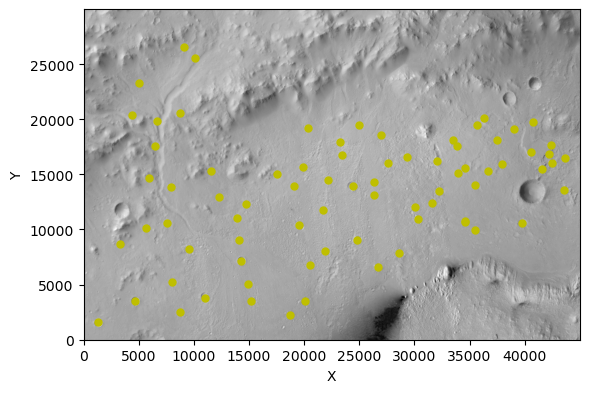

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import library as lib
from scipy.integrate import solve_ivp

from rich.traceback import install
install(show_locals = True)

# Set Options
np.set_printoptions(precision=4)


X, Y, map_image, obstacleMap, xLM, yLM, Xvec, Yvec = lib.load_data()

# Define Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> both these variables must be one-dimensional vectors
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4       # cm/s - max speed

# Define Specific Poses
P0 = np.array([42.38*1e3, 11.59*1e3, np.pi/2])          # m, m, rad
P1 = np.array([33.07*1e3, 19.01*1e3, np.pi])            # m, m, rad

# Show Original Map
plt.figure()
lib.plot_map(map_image, Xvec, Yvec)
plt.show()

# Obstacle map in grayscale
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Landmarks on grayscale map
plt.figure()
plt.imshow(map_image, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### Testing the Conversion

In [2]:
# Compute Relative States
R0 = lib.P2R(P0, P1)
R1 = lib.P2R(P1, P1)

# Convert backwards the Relative State into Pose State
P0p = lib.R2P(R0, P1)

print('\nThe Initial Pose State is P0:\n', P0)
print('\nThe Relative Pose State is R0:\n', R0)
print("\nThe Backconverted Initial Pose State is P0':\n", P0p)


The Initial Pose State is P0:
 [4.2380e+04 1.1590e+04 1.5708e+00]

The Relative Pose State is R0:
 [1.1905e+04 8.9789e-01 6.7290e-01]

The Backconverted Initial Pose State is P0':
 [4.2380e+04 1.1590e+04 1.5708e+00]


## Task 1: Move to a Pose

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows:
`K = [0.1, 1, -1]`


Task 1
______________________________________________________________________ 

The Initial State is:	 [4.2380e+04 1.1590e+04 1.5708e+00]
The Final State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]
The Desired State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]

The Delta State is:	 [ 1.0264e-01 -2.5248e-08 -1.1174e-06]


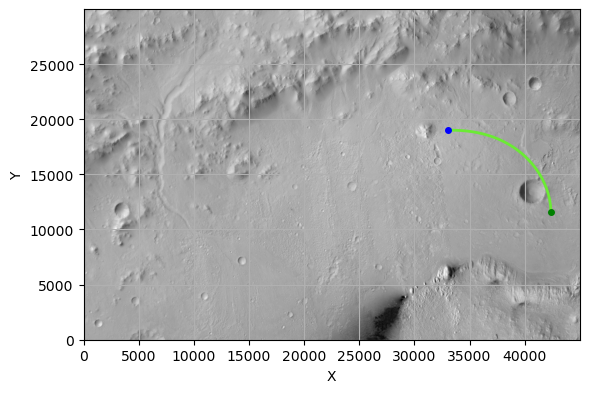

In [3]:
# Define the event function
rho_tol = 0.1    # m
def event(t, R):
    return R[0] - rho_tol
event.terminal = True

# Define Initial Relative State
R0 = lib.P2R(P0, P1)

# Define Time Domain
t0 = 0              # seconds
tf = 500            # seconds - maximum time for the maneuver
N = 1000            # time steps
tspan = np.linspace(t0, tf, N)

# Select Gains
K = np.array([1e-1, 1, -1])

# Solve the differential equation
sol = solve_ivp(lambda t, R: lib.KinematicModel(t, R, K), [t0, tf], R0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
R = sol.y
P = lib.R2P(R, P1)

# Log Results
print('\nTask 1\n' + '_'*70, '\n\nThe Initial State is:\t', P0)
print('The Final State is:\t', P[:, -1])
print('The Desired State is:\t', P1)
print('\nThe Delta State is:\t', P[:, -1] - P1)

# Show Trajectory
plt.figure("Task 1 - Trajectory")
lib.plot_map(map_image, Xvec, Yvec)
plt.plot(P[0, :], P[1, :], '#6beb34', linewidth=2)
plt.plot(P0[0], P0[1], 'go', markersize=4)
plt.plot(P1[0], P1[1], 'bo', markersize=4)
plt.show()
